In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('default')
import quandl
from sklearn import linear_model as lm
from sklearn.metrics import mean_squared_error
import math
from statsmodels.tsa.arima.model import ARIMA


In [68]:
import pandas as pd
import requests
import numpy as np

def get_treasury_yield_data(api_endpoint, api_params):
    """
    Retrieves Treasury Yield Curve data from the Quandl API and returns a Pandas DataFrame.

    Parameters:
    api_endpoint (str): API endpoint for Treasury Yield Curve data
    api_params (dict): Dictionary containing parameters for API request

    Returns:
    pd.DataFrame: Pandas DataFrame containing Treasury Yield Curve data
    """

    response = requests.get(api_endpoint, params=api_params)
    response_json = response.json()

    data = pd.DataFrame(response_json['dataset_data']['data'], columns=response_json['dataset_data']['column_names'])

    # Convert date column to datetime format
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Remove 2 month column
    data.drop('2 MO', axis=1, inplace=True)
    data.sort_index(inplace=True)

    return data

In [69]:
# Define API endpoint and parameters
url = 'https://data.nasdaq.com/api/v3/datasets/USTREASURY/YIELD/data'
params = {
    'api_key': 'ssjLTYPtW7EPob1yJxJE',
    'limit': 100000,
    'start_date': '2013-01-01', 
    'end_date': '2017-01-31'
}

data = get_treasury_yield_data(url, params)

# # Print first 5 rows of DataFrame
data

,1 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,
2013-01-02,0.07,0.08,0.12,0.15,0.27,0.37,0.76,1.25,1.86,2.63,3.04
2013-01-03,0.06,0.08,0.12,0.15,0.27,0.40,0.81,1.31,1.92,2.70,3.12
2013-01-04,0.06,0.07,0.11,0.15,0.27,0.41,0.82,1.32,1.93,2.70,3.10
2013-01-07,0.05,0.07,0.11,0.15,0.27,0.41,0.82,1.31,1.92,2.70,3.10
2013-01-08,0.06,0.07,0.11,0.14,0.25,0.38,0.79,1.28,1.89,2.66,3.06
...,...,...,...,...,...,...,...,...,...,...,...
2017-01-25,0.48,0.50,0.61,0.82,1.23,1.52,1.99,2.33,2.53,2.84,3.10
2017-01-26,0.49,0.51,0.62,0.82,1.21,1.49,1.95,2.30,2.51,2.82,3.08
2017-01-27,0.49,0.52,0.63,0.82,1.22,1.48,1.94,2.28,2.49,2.80,3.06


Step 1: Assume a value of lamda, and fit beta1(t), beta2(t), beta3(t) to a set of yields observed on day t
(repeat for all days in the dataset)

In [70]:
maturity = np.array([1/12, 3/12, 6/12, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0, 30.0])

### <a name="NS"></a> Nelson-Siegel Yield Curves
One of the traditional difficulties in fitting yield curves has been the multitude of different forms they can take. Nelson and Siegel modeled the term structure using a three-component functional form which can be fitted using OLS regression. Where $\tau$ is the maturity date and $\lambda$ controls the exponential decay rate. 


$$\begin{equation}
    f_t(\tau) = \beta_1^t + \beta_2^t e^{-\lambda_t \tau} + \beta_3^t \lambda e^{-\lambda_t \tau}
    \tag{eq: 4}
\end{equation}$$

In Diebold and Li's paper, they factor the orignal Nelson-Seigel curve into a Laguerre function-- a polynomial times an exponential decay-- which have more intutive parameter interpretations. 

$$\begin{equation}
f_t(\tau) = \beta_1^t + \beta_2^t \left( \frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau} \right) + \beta_3^t \left(\frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau} - e^{-\lambda_t \tau}\right)
\tag{eq: 5}
\end{equation}$$

In Diebold and Li's interpreation, $\beta_1$, $\beta_2$, $ \beta_3$ correspond to three latent dynamic factors: the long-term factor, the short-term factor, and the medium-term factor. These factors can be further interpreted as the level, slope, and curvature of the yield curve. _Figure 1_ shows the factor loading curves as a function of maturity date.

<!---
Here is the figure of NS curve loadings
-->

 The shape of the curve is in turn governed by the variations in $\beta_1$, $\beta_2$, and $\beta_3$. Stylistically, yield curves are more volatile in the short-term than the long-run. Long rates are also more persistent than short rates.

Diebold and Li also assign empirical interpretations to each loading. $\beta_1$ corresponds to the 10-year yield, and will effect all terms equally. $\beta_2$ is defined as the difference between the 10-year yield and the 3-month yield. $\beta_3$, the medium-term loading is interpreted as the difference between twice the 24 month  yield and the sum of 120 and 3 month yields.

Loading | Empirical Interpretation (months)         | Nelson-Siegel Fit            
---     | -------------------------------------------------- |------------------------
$\beta_1$| $y_t(120)$                        | 1                 
$\beta_2$| $y_t(120) - y_t(3)$               | $\frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau}$
$\beta_3$| $2y_t(24) -(y_t(120) + y_t(3))$   | $ \frac{1 -e^{-\lambda_t \tau}}{\lambda_t \tau} - e^{-\lambda_t \tau}$

Table 1: Nelson-Siegel Loadings


<a name="OLS"></a> FITTING THE NELSON-SIEGEL CURVE TO HISTORICAL YIELDS VIA OLS


Diebold and Li's model can be broadly viewed as a two-component model: first they fit historical data to the Nelson-Siegel parameters using OLS; secondly, they forecast the Nelson-Siegel parameters using an autoregressive model. This section will detail the use of OLS in fitting the term structure.


## Diebold and Li's Dataset
Diebold and Li use end-of-month price quotes for US treasuries taken from January 1985 to December 2000 taken from The Chicago Booth Center from Research in Security Prices (CRSP) government bond files. These prices are fitted such that bonds with options and those with maturity dates less than one month. The bonds are then converted into unsmoothed Fama-Bliss forward rates. Diebold and Li choose only bonds with fixed maturities, specifically those with maturity dates of 3, 6, 9, 12, 15, 18, 21, 24, 30, 36, 48, 72, 96, 108, and 120 months. A contour plot of the dataset used can be seen (and explored!) below.

In [71]:
def fit_NS_yield_curve(lambda_ ,df, maturity):
    """
    Perform Nelson-Siegel regression on CMT rates data.
    
    Args:
    - l: float, lambda value
    - df: pandas DataFrame, CMT rates data
    - maturity: list, maturities of CMT rates
    
    Returns:
    - A tuple containing the following:
        - float: average R-squared over the period of analysis
        - pandas Series: NS parameters (beta_0, beta_1, beta_2)
        - pandas Series: RMSE on each day
        - float: average RMSE over the period of analysis
    """

    # NS factor loadings for lambda at different maturity
    a2 = ((1-np.exp(-lambda_*maturity))/(lambda_*maturity))
    a3 = ((1-np.exp(-lambda_*maturity))/(lambda_*maturity) -np.exp(-lambda_*maturity))

    a2a3 = np.array((a2,a3)).T
    X= pd.DataFrame(a2a3)

    linearRegression = lm.LinearRegression()
    b0=[]
    b1 = []
    b2 = []
    r2 = []
    rmse = []

    for date in df.index:
        
        y = df.loc[date]
        
        linearRegression.fit(X=X,y=y)
        b0.append(linearRegression.intercept_)
        b1.append(linearRegression.coef_[0])
        b2.append(linearRegression.coef_[1])
        
        r2.append(linearRegression.score(X,y))
        avgR2 = np.mean(r2)
        
        y_predict = linearRegression.predict(X)     
        
        regression_model_mse = mean_squared_error(y,y_predict)
        mse = math.sqrt(regression_model_mse)
        rmse.append(mse)
        avgRMSE = np.mean(rmse)
         
    return avgR2, b0, b1, b2, rmse, avgRMSE

In [72]:
def plot_yield_curve(date, regr_result, lambda_, maturity, original_df, title = 'NS Model'):

    """
    Plots the yield curve for a given date using Nelson-Siegel model parameters and maturity values.
    
    Parameters:
        date (str or datetime): Date to plot the yield curve for.
        regr_result (tuple): Nelson-Siegel model parameters (b0, b1, b2).
        lamda (float): Lambda value to use.
        maturity (list or array-like): Maturities of the CMT rates.
        original_df (pandas.DataFrame): Dataframe of original CMT rates.
        title (str, optional): Title of the plot. Default is "Yield Curve".
        
    Returns:
        curve_ (numpy.array): Values of the yields on each maturity.
    """
    
    a2 = ((1-np.exp(-lambda_*maturity))/(lambda_*maturity))
    a3 = ((1-np.exp(-lambda_*maturity))/(lambda_*maturity) -np.exp(-lambda_*maturity))
    a2a3 = np.array((a2,a3))
  
    #Calculation of predicted values
    cur = (regr_result[['b1','b2']].loc[date].to_numpy().reshape(2,1) * a2a3).T
    print(cur)
    curve = np.sum(cur, axis=1)
    curve_ = curve + regr_result[['b0']].loc[date].values[0]
    
    #plot yeild curve
    plt.plot(maturity,curve_, label = title)
    plt.plot(maturity, original_df.loc[date], 'ro',label= 'Actual Data')
    plt.legend(loc = 4)
    plt.title(str(date)+' '+ title + ' Vs Actual Data')
    
    return curve_


[[-3.09171278  0.01427462]
 [-3.07608849  0.04253532]
 [-3.05284913  0.08421316]
 [-3.00707002  0.16505453]
 [-2.91823715  0.31707365]
 [-2.83290328  0.45692512]
 [-2.67211962  0.70332581]
 [-2.52356448  0.91016304]
 [-2.32139327  1.15739487]
 [-1.79199314  1.59357607]
 [-1.42356789  1.68423926]]


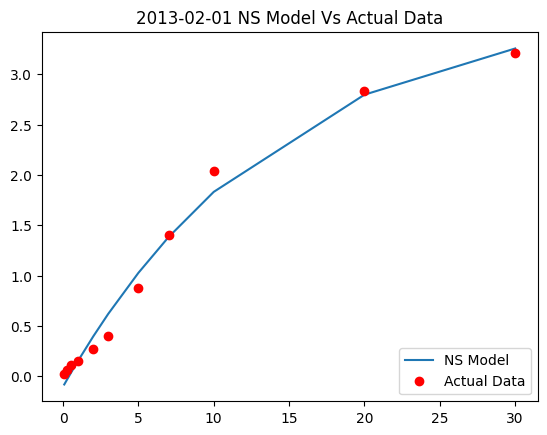

In [73]:
linearRegression = fit_NS_yield_curve(0.0609, data, maturity)
linearRegression_result = pd.DataFrame(columns=['b0','b1','b2','Date','RMSE'])
linearRegression_result['Date'] = data.index
linearRegression_result.set_index('Date', inplace=True)
linearRegression_result['Rsqaure'] = linearRegression[0]
linearRegression_result['b0'] = linearRegression[1]
linearRegression_result['b1'] = linearRegression[2]
linearRegression_result['b2'] = linearRegression[3]
linearRegression_result['RMSE'] = linearRegression[4]


plot_yield_curve('2013-02-01', linearRegression_result, 0.0609, maturity,data)
plt.show()

## Step 2
Find lambda that bests fitsthe whole dataset (Step1 needs to be repeated on each iteration; as you search for optimal lambda). You can use an optimization package, or write your own code


In [74]:
def enumerate_list(li):
    return [(y,x) for x,y in enumerate(li)]


In [75]:
def DNS_opt_lambda(lambdas, df, maturity):
    
    """
    Calculates the Nelson-Siegel model parameters and RMSE for each day in a dataframe
    for a range of lambda values, and returns the optimal lambda along with the corresponding
    NS parameters and RMSE values.

    Args:
    - lams (list): list of lambda values to evaluate
    - df (DataFrame): dataframe containing CMT rates
    - maturity (list): list of maturities of CMT rates

    Returns:
    - regr_result (DataFrame): dataframe containing the optimal lambda, NS parameters, and RMSE values
    """  
    
    b0 = []
    b1 = []
    b2 = []
    rmse = []
    avgRMSE = []
    rsquare=[]
    
    # For loop to find optimal lambda
    for lam in lambdas:
        para = fit_NS_yield_curve(lam,df,maturity)
        b0.append(para[1])
        b1.append(para[2])
        b2.append(para[3])
        rmse.append(para[4])
        avgRMSE.append(para[5]) 
        rsquare.append(para[0])
        
    # Sort result in order of max rsqaure
    maxrsqare = enumerate_list(rsquare)
    maxrsqare.sort(reverse=True)
    pos = maxrsqare[0][1]
    lambda_pos = lambdas[pos]
    
    # Regression Results for optimal lambda
    linearRegression_result = pd.DataFrame(columns=['b0','b1','b2','Date','RMSE'])
    linearRegression_result['Date'] = df.index
    linearRegression_result.set_index('Date', inplace=True)
    linearRegression_result['b0'] = b0[pos]
    linearRegression_result['b1'] = b1[pos]
    linearRegression_result['b2'] = b2[pos]
    linearRegression_result['RMSE'] = rmse[pos]
    
    return lambda_pos, linearRegression_result

In [76]:
lambda_values = np.arange(0.1, 0.8, 0.01)
optimal_result = DNS_opt_lambda(lambda_values, data, maturity)

In [77]:
optimal_lambda = optimal_result[0]
optimal_lambda

0.45999999999999985

In [78]:
ns_parameters = optimal_result[1]
ns_parameters.head()

,b0,b1,b2,RMSE
Date,,,,
2013-01-02,3.530290,-3.345847,-4.655771,0.074307
2013-01-03,3.619381,-3.445613,-4.683832,0.069898
2013-01-04,3.605152,-3.443016,-4.606351,0.065583
2013-01-07,3.601272,-3.441751,-4.603493,0.067637
2013-01-08,3.563649,-3.396826,-4.642626,0.066069


[[-3.55147062 -0.08825663]
 [-3.41958158 -0.25165983]
 [-3.23384041 -0.46669402]
 [-2.90161764 -0.80432035]
 [-2.3666807  -1.20579152]
 [-1.96323709 -1.37344112]
 [-1.4161047  -1.37427785]
 [-1.07929783 -1.21963635]
 [-0.77904086 -0.96908576]
 [-0.39343583 -0.51291568]
 [-0.26231679 -0.34229141]]


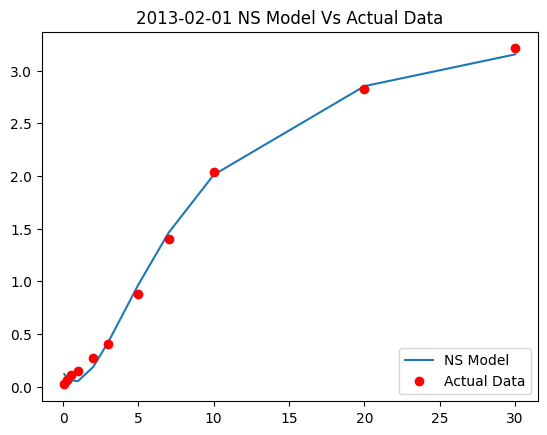

In [79]:
plot_yield_curve('2013-02-01', ns_parameters, optimal_lambda, maturity, data)
plt.show()

# QUESTION 2

### Step 1: Compute RMSE for each day in the sample and pick 20 days with largest RMSE

In [80]:
RMSE_Top = ns_parameters.sort_values('RMSE', ascending=False)
RMSE_Top20 = RMSE_Top.head(20)
RMSE_Top20

,b0,b1,b2,RMSE
Date,,,,
2013-12-31,4.754374,-4.798104,-4.163603,0.124981
2013-12-24,4.670330,-4.718381,-4.018781,0.120612
2013-12-27,4.722419,-4.770882,-4.097303,0.120042
2014-01-02,4.703532,-4.744532,-4.145468,0.119171
2014-04-24,4.057351,-4.195183,-2.721228,0.118576
2014-04-21,4.134586,-4.240909,-2.918604,0.118343
2013-12-30,4.676927,-4.716030,-4.104629,0.117918
2014-04-17,4.130603,-4.244456,-2.883076,0.117253
2014-04-22,4.098111,-4.214708,-2.772326,0.116835


### Step 2: Use 4m of data prior to each of the 20 days to fit AR(1) to each of beta1(t); beta2(t); beta3(t) time series and compute half-lives (HL). Generate t+5d forecast for each yield on each of the 20 days, using the corresponding set of AR(1) models (combined with the DNS model yield formula) for each forecast.

In [81]:
def AR1_hf_fc_nsfactors(date, df_ns_parameters, past_days, forcast_days):
    
    """ This function takes in four inputs:

    date: The date on which the AR1 model ends.
    df_ns_parameters: A data frame containing betas corresponding to optimal lambda.
    past_days: The number of days up to the date to be considered for analysis.
    forcast_days: The number of forecasts to be generated.
    The function returns two values in a list:

    halflife: A DataFrame containing the half-life of the betas selected in the sample.
    predicted_betas: A DataFrame containing the predicted values of beta based on the fitted AR1 model."""

    ind = np.where(df_ns_parameters.index==date)
    pos = ind[0][0]
    
    halfLife = []
    forcast = []
    
    # for loop to calculate AR1 model parameters and half-life
    for ns_factor in df_ns_parameters.columns[:3]:
        b = df_ns_parameters.iloc[pos-past_days:pos][ns_factor]
        model = ARIMA(b, order=(1,0,0)).fit()

        h = -math.log(2)/math.log(model.arparams)
        halfLife.append(h)
        
        forcast_b = model.forecast(forcast_days+1)
        forcast.append(forcast_b)
    
    # forecasted Betas
    predicted_betas = pd.DataFrame(np.array(forcast).T)
    predicted_betas.columns = df_ns_parameters.columns[:3]
    betas_index = df_ns_parameters.iloc[pos:pos+forcast_days+1].index
    predicted_betas['Date'] = betas_index
    predicted_betas.set_index('Date', inplace=True)
    predicted_betas
    
    # half-life
    halflife = pd.DataFrame(columns=['Parameters', 'Half Life'])
    halflife['Parameters'] = df_ns_parameters.columns[:3]
    halflife.set_index('Parameters', inplace = True)
    halflife['Half Life'] = halfLife
    
    return halflife, predicted_betas

In [82]:
Predicted_beta_5d = []
half_life_5 = []
for date in RMSE_Top20.index:
    Predicted_5 = AR1_hf_fc_nsfactors(date, ns_parameters, 80, 5)
    Predicted_beta_5d.append(Predicted_5[1])
    half_life_5.append(Predicted_5[0])

[print('\n Calendar 4 months '+str(RMSE_Top20.index[i])+'\n',half_life_5[i]) for i in range(0,20)]


/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be g


 Calendar 4 months 2013-12-31 00:00:00
             Half Life
Parameters           
b0           8.043147
b1           9.740199
b2          25.202100

 Calendar 4 months 2013-12-24 00:00:00
             Half Life
Parameters           
b0           7.097500
b1           7.852146
b2          18.328151

 Calendar 4 months 2013-12-27 00:00:00
             Half Life
Parameters           
b0           8.206156
b1           9.193248
b2          20.992069

 Calendar 4 months 2014-01-02 00:00:00
             Half Life
Parameters           
b0           9.203017
b1          12.147242
b2          31.332868

 Calendar 4 months 2014-04-24 00:00:00
             Half Life
Parameters           
b0          50.371859
b1          26.653650
b2          28.073287

 Calendar 4 months 2014-04-21 00:00:00
             Half Life
Parameters           
b0          20.718488
b1          16.912465
b2          23.147090

 Calendar 4 months 2013-12-30 00:00:00
             Half Life
Parameters           
b0       

/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency informatio

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [83]:
[print('\n 4 month data points '+str(RMSE_Top20.index[i])+'\n',Predicted_beta_5d[i]) for i in range(0,20)]


 4 month data points 2013-12-31 00:00:00
                   b0        b1        b2
Date                                    
2013-12-31  4.665413 -4.703999 -4.106867
2014-01-02  4.654849 -4.692796 -4.109044
2014-01-03  4.645157 -4.682361 -4.111162
2014-01-06  4.636266 -4.672644 -4.113222
2014-01-07  4.628109 -4.663594 -4.115227
2014-01-08  4.620625 -4.655166 -4.117177

 4 month data points 2013-12-24 00:00:00
                   b0        b1        b2
Date                                    
2013-12-24  4.597752 -4.633439 -4.043859
2013-12-26  4.590022 -4.622795 -4.053148
2013-12-27  4.583012 -4.613050 -4.062092
2013-12-30  4.576654 -4.604128 -4.070705
2013-12-31  4.570888 -4.595961 -4.078997
2014-01-02  4.565658 -4.588483 -4.086982

 4 month data points 2013-12-27 00:00:00
                   b0        b1        b2
Date                                    
2013-12-27  4.670852 -4.721629 -3.998181
2013-12-30  4.658876 -4.707165 -4.005941
2013-12-31  4.647871 -4.693750 -4.013450
2014-01-02

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Step 3. Do these forecasts perform better than those generated under the random walk assumption?

## Yield Curve Using predicted betas Vs Optimal Betas

[[-4.68059764 -0.07655328]
 [-4.50677682 -0.21828826]
 [-4.26198255 -0.40480765]
 [-3.82413545 -0.69766274]
 [-3.11912481 -1.04589648]
 [-2.58741347 -1.19131476]
 [-1.86633004 -1.19204053]
 [-1.42244142 -1.05790541]
 [-1.02672307 -0.8405793 ]
 [-0.51852176 -0.44490004]
 [-0.34571575 -0.29690156]]
[[-4.63227677 -0.0747013 ]
 [-4.46025042 -0.21300743]
 [-4.21798332 -0.39501454]
 [-3.7846564  -0.68078488]
 [-3.08692404 -1.02059414]
 [-2.56070191 -1.16249446]
 [-1.8470627  -1.16320268]
 [-1.40775662 -1.03231255]
 [-1.01612353 -0.82024399]
 [-0.51316872 -0.43413702]
 [-0.3421467  -0.28971891]]


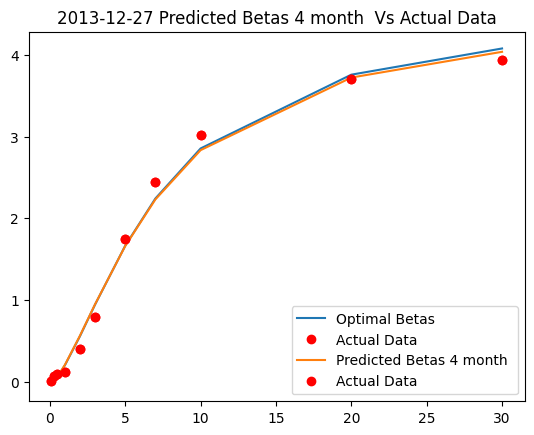

In [84]:
plot_yield_curve('2013-12-27', ns_parameters, optimal_lambda, maturity, data, 'Optimal Betas')
plot_yield_curve('2013-12-27', Predicted_beta_5d[2], optimal_lambda, maturity, data, 'Predicted Betas 4 month ')
plt.show()

To fit random walk model ARIMA(0,1,0) model is used that has AR1 model with slope coefficient equal to 1.

In [85]:
def randomwalk_hf_fc_nsfactors(date, df_nsparameters, past_days, forcast_days):
    
    ind = np.where(df_nsparameters.index==date)
    pos = ind[0][0]
    
    forcast = []
    
    for ns_factor in df_nsparameters.columns[:3]:
        b = df_nsparameters.iloc[pos-past_days:pos][ns_factor]
        model = ARIMA(b, order=(0,1,0)).fit()
        forcast_b = model.forecast(forcast_days+1)
        forcast.append(forcast_b)
    
    predicted_betas = pd.DataFrame(np.array(forcast).T)
    predicted_betas.columns = df_nsparameters.columns[:3]
    betas_index = df_nsparameters.iloc[pos:pos+forcast_days+1].index
    predicted_betas['Date'] = betas_index
    predicted_betas.set_index('Date', inplace=True)
    predicted_betas
    
    return  predicted_betas

In [86]:
Predicted_beta_5d_random_walk = []
half_life_5_random_walk = []

for date in RMSE_Top20.index:
    Predicted_5_random_walk = randomwalk_hf_fc_nsfactors(date, ns_parameters, 80 , 5)
    Predicted_beta_5d_random_walk.append(Predicted_5_random_walk)

[print('\n 4 month points '+str(RMSE_Top20.index[i])+'\n') for i in range(0,5)]


/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be g


 4 month points 2013-12-31 00:00:00


 4 month points 2013-12-24 00:00:00


 4 month points 2013-12-27 00:00:00


 4 month points 2014-01-02 00:00:00


 4 month points 2014-04-24 00:00:00



/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/kohsheentiku/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency informatio

[None, None, None, None, None]

[[-4.63227677 -0.0747013 ]
 [-4.46025042 -0.21300743]
 [-4.21798332 -0.39501454]
 [-3.7846564  -0.68078488]
 [-3.08692404 -1.02059414]
 [-2.56070191 -1.16249446]
 [-1.8470627  -1.16320268]
 [-1.40775662 -1.03231255]
 [-1.01612353 -0.82024399]
 [-0.51316872 -0.43413702]
 [-0.3421467  -0.28971891]]
[[-4.64757913 -0.07455144]
 [-4.4749845  -0.21258011]
 [-4.23191709 -0.39422208]
 [-3.79715871 -0.67941913]
 [-3.09712145 -1.01854669]
 [-2.56916098 -1.16016234]
 [-1.85316432 -1.16086913]
 [-1.41240704 -1.03024159]
 [-1.01948022 -0.81859847]
 [-0.51486393 -0.43326608]
 [-0.34327696 -0.2891377 ]]


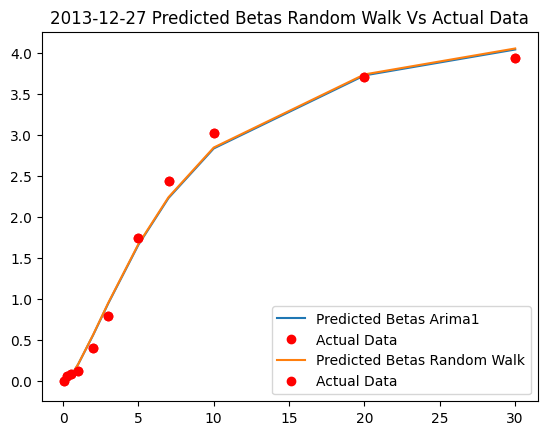

In [87]:
plot_yield_curve('2013-12-27', Predicted_beta_5d[2], optimal_lambda, maturity, data, 'Predicted Betas Arima1')
plot_yield_curve('2013-12-27', Predicted_beta_5d_random_walk[2], optimal_lambda, maturity, data, 'Predicted Betas Random Walk')
plt.show()

The forecasts perform same as those generated under the random walk assumption, we can see it in the above figure as both the curves(Predicted betas AR1 and Predicted Betas Random Walk) overlap on each other